# Importing all necessary modules, packages & data

In [172]:
# Data manipulation & vizualisation tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Models
from sklearn.linear_model import LinearRegression, LassoCV,  BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
# Scalers, encoders, metrics & tools for modeling
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from mlxtend.preprocessing import DenseTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.simplefilter('ignore')

In [145]:
df = pd.read_csv('Data/clean_data.csv')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_sold      21597 non-null  object 
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  int64  
 3   m2_living      21597 non-null  float64
 4   m2_total       21597 non-null  float64
 5   floors         21597 non-null  int64  
 6   waterfront     21597 non-null  bool   
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  m2_above       21597 non-null  float64
 11  m2_basement    21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  int64  
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  m2_living15    21597 non-null  float64
 18  m2_tot

We decided to keep everything in the data wrangling process, so now it's time to prune out dataset a bit. We'll start by plotting a correlation heatmap and checking for correlation between our categorical variables to make some decisions.

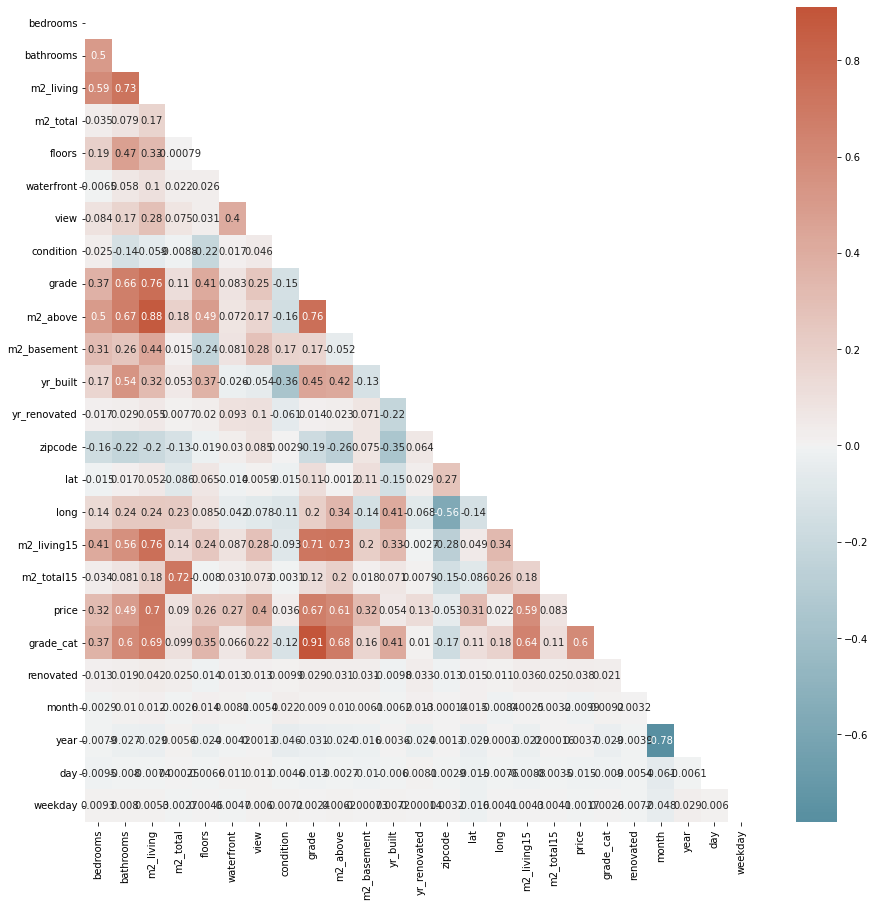

In [63]:
correlations_matrix = df.corr()
mask=np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)]=True
fig, ax = plt.subplots(figsize=(15,15))
ax=sns.heatmap(correlations_matrix, mask=mask, annot=True, center=0, 
               cmap=sns.diverging_palette(220, 20, as_cmap=True));

In [77]:
feat_crosstab = pd.crosstab(df['basement_cat'], df['yr_built_bins'], margins=False)
stats.chi2_contingency(feat_crosstab, correction=False)

(1690.1580357094874,
 0.0,
 12,
 array([[ 589.61689123,  559.6518961 ,  562.79233227,  560.04445062,
          553.89442978],
        [ 575.2207251 ,  545.98735936,  549.05111821,  546.37032921,
          540.37046812],
        [2735.2715655 , 2596.26198083, 2610.83067093, 2598.08306709,
         2569.55271565],
        [ 605.89081817,  575.09876372,  578.32587859,  575.50215308,
          569.18238644]]))

Based on the correlation heatmap, the general approach we'll take is to run a simple baseline model and then start applying several models to the features that correlate the most with price first. This decision comes from the sheer amount of variables involved, and the weak correlation that most of them have with price. From this 'pure' model (in terms of features included) we'll start iterating and including more variables, different scalers/encoders, etc.

# Modeling
We already have clean, ready-to-work data at hand, so it's time to start modeling to predict 'price'!

## Baseline model
We'll use simple linear regression on the original features of the dataset (no extracted columns) with no transformations. The only exception we will make is that we use the columns extracted from date: day, weekday, month and year.  
We will try 2 iterations: one with m2_living and m2_total and the other one with m2_living15 and m2_total15 in order to decide, from the very beginning, which one of them we'll keep.

- **Disclaimer:** We will follow the same process for every modeling iteration in terms of separating features from label, applying transformations to the data, doing the train/test split, fitting the models, doing predictions and getting the error metrics, so the steps of the process will only be detailed for this baseline model. In the following iterations, only the specific changes and decisions made for that iteration will be made explicit, and preprocessing will be embedded into the modeling pipelines.

### Separating features from label
Our label, of course, is the price, and we'll only keep the original features of the dataset (with either m2_living or m2_living15).

In [93]:
df['waterfront'] = df['waterfront'].astype(int)

y = df['price']

X = df.drop(['price', 'date_sold', 'basement_cat', 
             'renovated', 'grade_cat', 'yr_built_bins', 'm2_living15', 'm2_total15'], axis=1)

X_15 = df.drop(['price', 'date_sold', 'basement_cat', 
             'renovated', 'grade_cat', 'yr_built_bins', 'm2_living', 'm2_total'], axis=1)

### Preprocessing for the model
In this stage, data transformations such as scaling for numerical variables or encoding for categorical ones is performed. After that, the features have to be merged together in one dataframe in order to proceed to the next stage of the process. In our baseline model we're not going to perform any preprocessing steps, so we can move on!

### Train & test split
Once all transformations are applied and the features are merged back together, it's time to split the sample into training and testing subsamples to fit the model and do some predictions.

In [94]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_15,X_test_15,y_train_15,y_test_15 = train_test_split(X_15, y, test_size=0.3, random_state=42)

### Selecting the model, fitting it to the training subset and making predictions
Now it's time to select what model to use (for now, a simple linear regression will do), fit it to the training data and making some predictions on the test subset. At this point the work is pretty much done... assuming no hyperparameters have to be twitched!

In [66]:
lr = LinearRegression()
baseline = lr.fit(X_train,y_train)
baseline_15 = lr.fit(X_train_15,y_train_15)

In [67]:
preds = baseline.predict(X_test)
preds_15 = baseline_15.predict(X_test_15)

### Getting error metrics and interpreting them
We will be using the same error metrics for all our models: MSE, RMSE, MAE and R2. Some notes on the metrics:
- The units of the MSE are squared units. For example, if your target value represents “dollars,” then the MSE will be “squared dollars.” This can be confusing for stakeholders; therefore, when reporting results, often the root mean squared error is used instead (discussed in the next section). A perfect mean squared error value is 0.0, which means that all predictions matched the expected values exactly.
- The Root Mean Squared Error, or RMSE, is an extension of the mean squared error. Importantly, the square root of the error is calculated, which means that the units of the RMSE are the same as the original units of the target value that is being predicted. A perfect RMSE value is 0.0, which means that all predictions matched the expected values exactly.
- Mean Absolute Error, or MAE, is a popular metric because, like RMSE, the units of the error score match the units of the target value that is being predicted. Unlike the RMSE, the changes in MAE are linear and therefore intuitive. That is, MSE and RMSE punish larger errors more than smaller errors, inflating or magnifying the mean error score. This is due to the square of the error value. The MAE does not give more or less weight to different types of errors and instead the scores increase linearly with increases in error.
- R2 is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. It is scaled, meaning it goes from 0 to 1 for any magnitude, which makes it very convenient to compare models between them (if fitted to the same data).

In [68]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
mse_15 = mean_squared_error(y_test_15, preds_15)
rmse_15 = np.sqrt(mse_15)
mae_15 = mean_absolute_error(y_test_15, preds_15)
r2_15 = r2_score(y_test_15, preds_15)
print(f'{mse}, {rmse}, {mae}, R2 baseline: {r2}, {mse_15}, {rmse_15}, {mae_15}, R2 baseline15: {r2_15}')

3.9112947283793917e+20, 19776993523.7371, 19701192068.474556, R2 baseline: -2949728490.3158674, 41422046164.8345, 203524.06777782942, 125637.42419290914, R2 baseline15: 0.687612930688966


For some reason, the model using m2_living and m2_total gets abnormal error metrics, but the one using m2_living15 and m2_total15 does not. This last model gets an R2 of 0.68 and a RMSE of 203524, which can be interpreted as predicting the price with a deviation of roughly $200k. We'll keep this as out baseline model, and completely ditch the variables m2_living and m2_total. One last thing we ought to do is to store the metrics for the definitive baseline model in a proper way.

In [71]:
baseline_model = [round(rmse_15, 2), round(r2_15, 2)]

## Iteration 1
For the first modeling iteration we will only include original features that show a high correlation with price in order to reduce potential noise. The features included will be: bedrooms, bathrooms, m2_living15, floors, waterfront, view, grade, m2_basement (we'll exclude m2_above because its high correlation with m2_living15), yr_renovated and lat. We will still not do any preprocessing, but we will apply the following models: 

In [112]:
y = df['price']
X = df[['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade', 
        'm2_basement', 'yr_renovated', 'm2_living15', 'lat']]

In [113]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [119]:
linear_reg_params = [{}]
lasso_params = [{}]
svr_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
rand_for_params = [{'bootstrap': True,
                    'max_depth': 80,
                    'max_features': 3,
                    'min_samples_leaf': 5,
                    'min_samples_split': 12,
                    'n_estimators': 100,
                    "criterion": "absolute_error"}]
dec_tree_params = [{"max_depth": 5, 
                    "max_features": 'auto', 
                    "max_leaf_nodes": 50,
                    "min_samples_leaf": 2, 
                    "min_weight_fraction_leaf": 0.1,
                    "splitter": 'random'}]
kneighbors_params = [{"n_neighbors":5}, {"n_neighbors":10}, {"n_neighbors":30}, {"n_neighbors":100}]
#kneighbors_params = [{"n_neighbors":x for x in range(1, 25)}]
gbr_params = [{}]
kr_params = [{}]
br_params = [{}]


modelclasses = [
    ["linear regression", LinearRegression, linear_reg_params],
    ["lasso", LassoCV, lasso_params],
    ["support vector machines", SVR, svr_params],
    ["decision tree", DecisionTreeRegressor, dec_tree_params],
    ["random forest", RandomForestRegressor, rand_for_params],
    ["k neighbors", KNeighborsRegressor, kneighbors_params],
    ["gradient boosting", GradientBoostingRegressor, gbr_params],
    ["kernel ridge", KernelRidge, kr_params],
    ["bayesian ridge", BayesianRidge, br_params]
]


metrics_1 = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = (r2_score(y_test, preds), np.sqrt(mean_squared_error(y_test, preds)))
        metrics_1.append([modelname, params, score])

metrics_1.sort(key=lambda x:x[-1], reverse=True)
for modelname, params, score in metrics_1:
    print(modelname, params, score)

gradient boosting {} (0.7618907894090163, 177687.6924452232)
random forest {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100, 'criterion': 'absolute_error'} (0.7372764973108145, 186646.01099008566)
bayesian ridge {} (0.5971073951350061, 231134.03327254052)
linear regression {} (0.5971011047271936, 231135.83762640067)
kernel ridge {} (0.5374831094218893, 247646.9869676343)
lasso {} (0.5157197968747508, 253406.41667349634)
k neighbors {'n_neighbors': 10} (0.4453204595933339, 271200.3984820368)
k neighbors {'n_neighbors': 30} (0.44144446502783463, 272146.2971824653)
k neighbors {'n_neighbors': 5} (0.4174441220829952, 277931.67456452147)
k neighbors {'n_neighbors': 100} (0.41334940160544986, 278906.739574262)
decision tree {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'} (0.2998731073644507, 304689.5992890668)
support vector m

The best one was gradient boosting regression, with an R2 of 0.76 and a RMSE of 177687, which can be interpreted as predicting the price with a deviation of roughly $177k. We already have a candidate model better than the baseline one.

## Iteration 2
In this iteration we will use the same models as in Iteration 1 and we'll include all variables. This decision comes from the feature selection we (kind of) unsiccessfully performed (see section 4.1). Still no preprocessing will be applied.

In [120]:
y = df['price']
X = df.drop(['price', 'date_sold', 'basement_cat', 
             'renovated', 'grade_cat', 'yr_built_bins', 'm2_living', 'm2_total'], axis=1)

In [122]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [124]:
linear_reg_params = [{}]
lasso_params = [{}]
svr_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
rand_for_params = [{'bootstrap': True,
                    'max_depth': 80,
                    'max_features': 3,
                    'min_samples_leaf': 5,
                    'min_samples_split': 12,
                    'n_estimators': 100,
                    "criterion": "absolute_error"}]
dec_tree_params = [{"max_depth": 5, 
                    "max_features": 'auto', 
                    "max_leaf_nodes": 50,
                    "min_samples_leaf": 2, 
                    "min_weight_fraction_leaf": 0.1,
                    "splitter": 'random'}]
kneighbors_params = [{"n_neighbors":5}, {"n_neighbors":10}, {"n_neighbors":30}, {"n_neighbors":100}]
#kneighbors_params = [{"n_neighbors":x for x in range(1, 25)}]
gbr_params = [{}]
kr_params = [{}]
br_params = [{}]


modelclasses = [
    ["linear regression", LinearRegression, linear_reg_params],
    ["lasso", LassoCV, lasso_params],
    ["support vector machines", SVR, svr_params],
    ["decision tree", DecisionTreeRegressor, dec_tree_params],
    ["random forest", RandomForestRegressor, rand_for_params],
    ["k neighbors", KNeighborsRegressor, kneighbors_params],
    ["gradient boosting", GradientBoostingRegressor, gbr_params],
    ["kernel ridge", KernelRidge, kr_params],
    ["bayesian ridge", BayesianRidge, br_params]
]


metrics_2 = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = (r2_score(y_test, preds), np.sqrt(mean_squared_error(y_test, preds)))
        metrics_2.append([modelname, params, score])

metrics_2.sort(key=lambda x:x[-1], reverse=True)
for modelname, params, score in metrics_2:
    print(modelname, params, score)

gradient boosting {} (0.8660727436604989, 133261.2049168786)
random forest {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100, 'criterion': 'absolute_error'} (0.7957007751492254, 164589.68316537025)
bayesian ridge {} (0.6876215060612687, 203521.274277709)
linear regression {} (0.687612930688966, 203524.06777782942)
kernel ridge {} (0.6875613649560925, 203540.86494340078)
k neighbors {'n_neighbors': 5} (0.5796715985040102, 236082.40345745356)
k neighbors {'n_neighbors': 10} (0.5669782012929092, 239620.58805493225)
lasso {} (0.5344764762627946, 248450.6089721595)
k neighbors {'n_neighbors': 30} (0.5293553452150745, 249813.44883603722)
k neighbors {'n_neighbors': 100} (0.45173586497327844, 269627.48974309076)
decision tree {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'} (0.3725639189668585, 288439.00882119394)
support vector 

Again, the best performing model has been the gradient boosting regression, with an R2 of 0.86 and a RMSE of 133261, which can be interpreted as predicting the price with a deviation of roughly $133k. In general, our models improved by including every variable in the dataset.

## Iteration 3
After the improvement in Iteration 2 from including every variable, we will now keep them and use a StandardScaler().

In [125]:
y = df['price']
X = df.drop(['price', 'date_sold', 'basement_cat', 
             'renovated', 'grade_cat', 'yr_built_bins', 'm2_living', 'm2_total'], axis=1)

In [126]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [127]:
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

linear_reg_params = [{}]
lasso_params = [{}]
svr_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
rand_for_params = [{'bootstrap': True,
                    'max_depth': 80,
                    'max_features': 3,
                    'min_samples_leaf': 5,
                    'min_samples_split': 12,
                    'n_estimators': 100,
                    "criterion": "absolute_error"}]
dec_tree_params = [{"max_depth": 5, 
                    "max_features": 'auto', 
                    "max_leaf_nodes": 50,
                    "min_samples_leaf": 2, 
                    "min_weight_fraction_leaf": 0.1,
                    "splitter": 'random'}]
kneighbors_params = [{"n_neighbors":5}, {"n_neighbors":10}, {"n_neighbors":30}, {"n_neighbors":100}]
#kneighbors_params = [{"n_neighbors":x for x in range(1, 25)}]
gbr_params = [{}]
kr_params = [{}]
br_params = [{}]


modelclasses = [
    ["linear regression", LinearRegression, linear_reg_params],
    ["lasso", LassoCV, lasso_params],
    ["support vector machines", SVR, svr_params],
    ["decision tree", DecisionTreeRegressor, dec_tree_params],
    ["random forest", RandomForestRegressor, rand_for_params],
    ["k neighbors", KNeighborsRegressor, kneighbors_params],
    ["gradient boosting", GradientBoostingRegressor, gbr_params],
    ["kernel ridge", KernelRidge, kr_params],
    ["bayesian ridge", BayesianRidge, br_params]
]


metrics_3 = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        complete_pipeline = Pipeline([
            ('preprocessor', preprocessing_pipeline),
            ('estimator', model)
        ])
        complete_pipeline.fit(X_train, y_train)
        preds = complete_pipeline.predict(X_test)
        score = (r2_score(y_test, preds), np.sqrt(mean_squared_error(y_test, preds)))
        metrics_3.append([modelname, params, score])

metrics_3.sort(key=lambda x:x[-1], reverse=True)
for modelname, params, score in metrics_3:
    print(modelname, params, score)

gradient boosting {} (0.8672932442893029, 132652.59976668682)
random forest {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100, 'criterion': 'absolute_error'} (0.793920898057364, 165305.0899893568)
k neighbors {'n_neighbors': 5} (0.7430254358738411, 184592.6135693628)
k neighbors {'n_neighbors': 10} (0.7371180347821047, 186702.2905770692)
k neighbors {'n_neighbors': 30} (0.7078820375449137, 196810.5527915255)
lasso {} (0.6876439283565752, 203513.96984399456)
linear regression {} (0.6876129306889681, 203524.06777782872)
bayesian ridge {} (0.6875688580248251, 203538.42421638404)
k neighbors {'n_neighbors': 100} (0.622777446453576, 223649.57391379945)
decision tree {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'} (0.1655847654185748, 332629.1930187466)
support vector machines {'C': 10} (-0.03980060508354488, 371316.52952692116

Applying a Standard Scaler barely improved our results, maybe because of some strong outliers we have. One more time, the best performing model was gradient boosting, with an R2 of 0.86 and a RMSE of 132652, just a bit better than the last iteration.

## Iteration 4
Next, we will try including the categorical features into the equation. Now we will use the Robust Scaler for numerical variables and the One Hot Encoder for the categorical ones.

In [131]:
y = df['price']
X = df.drop(['price', 'date_sold', 'grade_cat', 'm2_living', 'm2_total'], axis=1)
numerical = X.select_dtypes(include=np.number).columns.to_list()
categorical = X.select_dtypes(exclude=np.number).columns.to_list()

In [134]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [138]:
num_pipeline = Pipeline([
    ('Robust_scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('OHE', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical_preprocessor', num_pipeline, numerical),
    ('categorical_preprocessor', cat_pipeline, categorical)
])

linear_reg_params = [{}]
lasso_params = [{}]
svr_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
rand_for_params = [{'bootstrap': True,
                    'max_depth': 80,
                    'max_features': 3,
                    'min_samples_leaf': 5,
                    'min_samples_split': 12,
                    'n_estimators': 100,
                    "criterion": "absolute_error"}]
dec_tree_params = [{"max_depth": 5, 
                    "max_features": 'auto', 
                    "max_leaf_nodes": 50,
                    "min_samples_leaf": 2, 
                    "min_weight_fraction_leaf": 0.1,
                    "splitter": 'random'}]
kneighbors_params = [{"n_neighbors":5}, {"n_neighbors":10}, {"n_neighbors":30}, {"n_neighbors":100}]
#kneighbors_params = [{"n_neighbors":x for x in range(1, 25)}]
gbr_params = [{}]
kr_params = [{}]
br_params = [{}]


modelclasses = [
    ["linear regression", LinearRegression, linear_reg_params],
    ["lasso", LassoCV, lasso_params],
    ["support vector machines", SVR, svr_params],
    ["decision tree", DecisionTreeRegressor, dec_tree_params],
    ["random forest", RandomForestRegressor, rand_for_params],
    ["k neighbors", KNeighborsRegressor, kneighbors_params],
    ["gradient boosting", GradientBoostingRegressor, gbr_params],
    ["kernel ridge", KernelRidge, kr_params],
    ["bayesian ridge", BayesianRidge, br_params]
]


metrics_4 = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        complete_pipeline = Pipeline([
            ('preprocessor', preprocessing_pipeline),
            ('estimator', model)
        ])
        complete_pipeline.fit(X_train, y_train)
        preds = complete_pipeline.predict(X_test)
        score = (r2_score(y_test, preds), np.sqrt(mean_squared_error(y_test, preds)))
        metrics_4.append([modelname, params, score])

metrics_4.sort(key=lambda x:x[-1], reverse=True)
for modelname, params, score in metrics_4:
    print(modelname, params, score)

gradient boosting {} (0.8633106256545364, 134628.3823946025)
random forest {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100, 'criterion': 'absolute_error'} (0.7728054237180612, 173567.42862938892)
k neighbors {'n_neighbors': 5} (0.7008500065937209, 199165.33384742762)
k neighbors {'n_neighbors': 10} (0.6987976881187496, 199847.35296701826)
bayesian ridge {} (0.6908619288125828, 202462.92005662693)
linear regression {} (0.6907136160738105, 202511.48125351843)
kernel ridge {} (0.6853229835178185, 204268.6702526196)
k neighbors {'n_neighbors': 30} (0.6714225589993507, 208731.56113439376)
lasso {} (0.6341317854223024, 220257.94873965578)
k neighbors {'n_neighbors': 100} (0.6010536987902505, 229999.2772294731)
decision tree {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'} (0.2284391495843885, 319855.88181457424)
support vector

Pretty much all models have worsened slightly in this iteration, but it could well be because of the different scaler used for numerical variables. Gradient booster regressor keeps yielding the best results with an R2 of 0.86 and a RMSE of 134628.

## Iteration 5
In this iteration we're going to treat many of the original features as categorical, which they really are. We are referring, for example, to 'bedrooms', 'floors' or 'grade'. So the first thing we're going to do is transforming these variables to categorical, and then we're going to encode them with OneHotEncoder again. For the remaining numerical variables, we're going to stick with the StandardScaler. Also, since encoding so many categorical variables returns a sparse matrix with many 0's, we need to implement a DenseTransformer to make it dense for models such as Random Forest, that won't take a sparse matrix as input.

In [161]:
y = df['price']
X = df.drop(['price', 'date_sold', 'grade_cat', 'm2_living', 'm2_total'], axis=1)
X[['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 
   'condition', 'grade', 'zipcode', 'renovated']] = X[['bedrooms', 'bathrooms', 'floors', 'waterfront', 
                                          'view', 'condition', 'grade', 'zipcode', 'renovated']].astype(object)
numerical = X.select_dtypes(include=np.number).columns.to_list()
categorical = X.select_dtypes(exclude=np.number).columns.to_list()

We're going to check, through several chi-squared tests, the correlation between 3 variables that are very similar in nature: condition, grade and grade_cat. The latter was created by us, and it combines the 13 possible values of the feature grade into 5, scaling it like the condition one.

In [155]:
feat_crosstab = pd.crosstab(X['condition'], X['grade'], margins=False)
stats.chi2_contingency(feat_crosstab, correction=False)

(1456.835876021546,
 9.198319936194968e-280,
 40,
 array([[1.34277909e-03, 3.62550354e-02, 3.24952540e-01, 2.73658378e+00,
         1.20500996e+01, 8.14395518e+00, 3.51136732e+00, 1.52271149e+00,
         5.35768857e-01, 1.19507339e-01, 1.74561282e-02],
        [7.87146363e-03, 2.12529518e-01, 1.90489420e+00, 1.60420429e+01,
         7.06385146e+01, 4.77404269e+01, 2.05838774e+01, 8.92623976e+00,
         3.14071399e+00, 7.00560263e-01, 1.02329027e-01],
        [6.49164236e-01, 1.75274344e+01, 1.57097745e+02, 1.32299671e+03,
         5.82559985e+03, 3.93718109e+03, 1.69756448e+03, 7.36152243e+02,
         2.59016530e+02, 5.77756170e+01, 8.43913507e+00],
        [2.62860582e-01, 7.09723573e+00, 6.36122610e+01, 5.35709867e+02,
         2.35891087e+03, 1.59424943e+03, 6.87380423e+02, 2.98083901e+02,
         1.04881372e+02, 2.33945918e+01, 3.41718757e+00],
        [7.87609390e-02, 2.12654535e+00, 1.90601472e+01, 1.60514794e+02,
         7.06800667e+02, 4.77685095e+02, 2.05959856e+02, 8.93

In [156]:
feat_crosstab = pd.crosstab(X['condition'], df['grade_cat'], margins=False)
stats.chi2_contingency(feat_crosstab, correction=False)

(1173.315625574987,
 7.928969814130955e-240,
 16,
 array([[3.62550354e-01, 2.73658378e+00, 2.01940547e+01, 5.03407881e+00,
         6.72732324e-01],
        [2.12529518e+00, 1.60420429e+01, 1.18378942e+02, 2.95101171e+01,
         3.94360328e+00],
        [1.75274344e+02, 1.32299671e+03, 9.76278094e+03, 2.43371672e+03,
         3.25231282e+02],
        [7.09723573e+01, 5.35709867e+02, 3.95316030e+03, 9.85464324e+02,
         1.31693152e+02],
        [2.12654535e+01, 1.60514794e+02, 1.18448576e+03, 2.95274760e+02,
         3.94592304e+01]]))

In [157]:
feat_crosstab = pd.crosstab(df['grade_cat'], X['grade'], margins=False)
stats.chi2_contingency(feat_crosstab, correction=False)

(86388.0,
 0.0,
 40,
 array([[1.25017364e-02, 3.37546882e-01, 3.02542020e+00, 2.54785387e+01,
         1.12190582e+02, 7.58230310e+01, 3.26920406e+01, 1.41769690e+01,
         4.98819280e+00, 1.11265454e+00, 1.62522573e-01],
        [9.43649581e-02, 2.54785387e+00, 2.28363199e+01, 1.92315785e+02,
         8.46831134e+02, 5.72323471e+02, 2.46764365e+02, 1.07009862e+02,
         3.76516183e+01, 8.39848127e+00, 1.22674446e+00],
        [6.96346715e-01, 1.88013613e+01, 1.68515905e+02, 1.41915460e+03,
         6.24901542e+03, 4.22334283e+03, 1.82094666e+03, 7.89657175e+02,
         2.77842339e+02, 6.19748576e+01, 9.05250729e+00],
        [1.73588924e-01, 4.68690096e+00, 4.20085197e+01, 3.53774228e+02,
         1.55778701e+03, 1.05281683e+03, 4.53935037e+02, 1.96849840e+02,
         6.92619808e+01, 1.54494143e+01, 2.25665602e+00],
        [2.31976663e-02, 6.26336991e-01, 5.61383525e+00, 4.72768440e+01,
         2.08175858e+02, 1.40693846e+02, 6.06618975e+01, 2.63061536e+01,
         9.255868

It is clear that we have to keep either grade or grade_cat, since they are extremely correlated, but the question is... should we keep grade or condition? They also appear to be highly correlated, but we don't really know the predictive capacity of each one. We finally decided to keep grade and drop both grade_cat and condition, since grade is the variable that most correlates with the other two and it might have more predictive capacity due to the variability of its values.

In [162]:
X = X.drop(['condition'], axis=1)
numerical = X.select_dtypes(include=np.number).columns.to_list()
categorical = X.select_dtypes(exclude=np.number).columns.to_list()

In [166]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [173]:
num_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('OHE', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical_preprocessor', num_pipeline, numerical),
    ('categorical_preprocessor', cat_pipeline, categorical)
])

linear_reg_params = [{}]
lasso_params = [{}]
svr_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
rand_for_params = [{'bootstrap': True,
                    'max_depth': 80,
                    'max_features': 3,
                    'min_samples_leaf': 5,
                    'min_samples_split': 12,
                    'n_estimators': 100,
                    "criterion": "absolute_error"}]
dec_tree_params = [{"max_depth": 5, 
                    "max_features": 'auto', 
                    "max_leaf_nodes": 50,
                    "min_samples_leaf": 2, 
                    "min_weight_fraction_leaf": 0.1,
                    "splitter": 'random'}]
kneighbors_params = [{"n_neighbors":5}, {"n_neighbors":10}, {"n_neighbors":30}, {"n_neighbors":100}]
#kneighbors_params = [{"n_neighbors":x for x in range(1, 25)}]
gbr_params = [{}]
kr_params = [{}]
br_params = [{}]


modelclasses = [
    ["linear regression", LinearRegression, linear_reg_params],
    ["lasso", LassoCV, lasso_params],
    ["support vector machines", SVR, svr_params],
    ["decision tree", DecisionTreeRegressor, dec_tree_params],
    ["random forest", RandomForestRegressor, rand_for_params],
    ["k neighbors", KNeighborsRegressor, kneighbors_params],
    ["gradient boosting", GradientBoostingRegressor, gbr_params],
    ["kernel ridge", KernelRidge, kr_params],
    ["bayesian ridge", BayesianRidge, br_params]
]


metrics_5 = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        complete_pipeline = Pipeline([
            ('preprocessor', preprocessing_pipeline),
            ('to_dense', DenseTransformer()), 
            ('estimator', model)
        ])
        complete_pipeline.fit(X_train, y_train)
        preds = complete_pipeline.predict(X_test)
        score = (r2_score(y_test, preds), np.sqrt(mean_squared_error(y_test, preds)))
        metrics_5.append([modelname, params, score])

metrics_5.sort(key=lambda x:x[-1], reverse=True)
for modelname, params, score in metrics_5:
    print(modelname, params, score)

gradient boosting {} (0.8606980873304335, 135908.86623075212)
kernel ridge {} (0.8158439618985162, 156265.18531880318)
bayesian ridge {} (0.8157370067317657, 156310.5570131255)
linear regression {} (0.8151051036479273, 156578.34975909843)
lasso {} (0.813860121044655, 157104.62245452023)
k neighbors {'n_neighbors': 5} (0.7435740856476308, 184395.4524006342)
k neighbors {'n_neighbors': 10} (0.7352533984702898, 187363.26539953184)
k neighbors {'n_neighbors': 30} (0.6981132344461161, 200074.29118932437)
k neighbors {'n_neighbors': 100} (0.6279374834667887, 222114.65264535337)
random forest {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100, 'criterion': 'absolute_error'} (0.5751568559058118, 237346.89626116105)
decision tree {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'} (0.2992351417401943, 304828.3864373857)
support vector 

## Iteration 6
For our next iteration, considering the (worse) results obtained in the last 2 iterations, where categorical variables have been included, we'll stick to numerical variables and apply a Robust Scaler to them.

In [176]:
y = df['price']
X = df.drop(['price', 'date_sold', 'basement_cat', 
             'renovated', 'grade_cat', 'yr_built_bins', 'm2_living', 'm2_total'], axis=1)

In [177]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [178]:
preprocessing_pipeline = Pipeline([
    ('scaler', RobustScaler())
])

linear_reg_params = [{}]
lasso_params = [{}]
svr_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
rand_for_params = [{'bootstrap': True,
                    'max_depth': 80,
                    'max_features': 3,
                    'min_samples_leaf': 5,
                    'min_samples_split': 12,
                    'n_estimators': 100,
                    "criterion": "absolute_error"}]
dec_tree_params = [{"max_depth": 5, 
                    "max_features": 'auto', 
                    "max_leaf_nodes": 50,
                    "min_samples_leaf": 2, 
                    "min_weight_fraction_leaf": 0.1,
                    "splitter": 'random'}]
kneighbors_params = [{"n_neighbors":5}, {"n_neighbors":10}, {"n_neighbors":30}, {"n_neighbors":100}]
#kneighbors_params = [{"n_neighbors":x for x in range(1, 25)}]
gbr_params = [{}]
kr_params = [{}]
br_params = [{}]


modelclasses = [
    ["linear regression", LinearRegression, linear_reg_params],
    ["lasso", LassoCV, lasso_params],
    ["support vector machines", SVR, svr_params],
    ["decision tree", DecisionTreeRegressor, dec_tree_params],
    ["random forest", RandomForestRegressor, rand_for_params],
    ["k neighbors", KNeighborsRegressor, kneighbors_params],
    ["gradient boosting", GradientBoostingRegressor, gbr_params],
    ["kernel ridge", KernelRidge, kr_params],
    ["bayesian ridge", BayesianRidge, br_params]
]


metrics_6 = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        complete_pipeline = Pipeline([
            ('preprocessor', preprocessing_pipeline),
            ('estimator', model)
        ])
        complete_pipeline.fit(X_train, y_train)
        preds = complete_pipeline.predict(X_test)
        score = (r2_score(y_test, preds), np.sqrt(mean_squared_error(y_test, preds)))
        metrics_6.append([modelname, params, score])

metrics_6.sort(key=lambda x:x[-1], reverse=True)
for modelname, params, score in metrics_6:
    print(modelname, params, score)

gradient boosting {} (0.8646736539949842, 133955.46229711693)
random forest {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100, 'criterion': 'absolute_error'} (0.7984984004331062, 163458.8724530024)
k neighbors {'n_neighbors': 5} (0.7085290404396829, 196592.47721825907)
k neighbors {'n_neighbors': 10} (0.7035425471922361, 198267.00041549702)
bayesian ridge {} (0.6876797176003575, 203502.31036241393)
linear regression {} (0.6876129306889676, 203524.0677778289)
k neighbors {'n_neighbors': 30} (0.6746445974814705, 207705.62643733821)
lasso {} (0.6341317854223024, 220257.94873965578)
k neighbors {'n_neighbors': 100} (0.604183356308811, 229095.35076088825)
kernel ridge {} (0.5381222101251, 247475.82989320706)
decision tree {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'} (0.28695578472393235, 307487.51044700603)
support vector m

# Models evaluation

# Extra takeaways

## Feature selection
We tried to perform feature selection on our features with Lasso regression. Methodologically, we succeeded, but apparently all of our variables are important for the model.
Since Lasso regression is very sensitive to outliers, we used the sklearn's Robustscaler() method on pipeline.

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
#alphas = [0.1,0.3, 0.5, 0.8, 1]
features = X.columns.to_list()
pipeline = Pipeline([('scaler', RobustScaler()), ('model', Lasso())])
#need to fit
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )
search.fit(X_train,y_train)
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
np.array(features)[importance > 0]

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .......model__alpha=0.1;, score=-47336839855.918 total time=   0.4s
[CV 2/5] END .......model__alpha=0.1;, score=-38867659224.922 total time=   0.4s
[CV 3/5] END .......model__alpha=0.1;, score=-42744562349.746 total time=   0.4s
[CV 4/5] END .......model__alpha=0.1;, score=-35951061541.018 total time=   0.3s
[CV 5/5] END .......model__alpha=0.1;, score=-37771943990.230 total time=   0.3s
[CV 1/5] END .......model__alpha=0.2;, score=-47336804616.199 total time=   0.3s
[CV 2/5] END .......model__alpha=0.2;, score=-38867635523.419 total time=   0.3s
[CV 3/5] END .......model__alpha=0.2;, score=-42744645924.115 total time=   0.3s
[CV 4/5] END .......model__alpha=0.2;, score=-35951043912.522 total time=   0.3s
[CV 5/5] END .......model__alpha=0.2;, score=-37771937812.958 total time=   0.3s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-47336769380.885 total time=   0.3s
[CV 2/5] END model__alpha=0.3000000000

[CV 2/5] END .......model__alpha=2.0;, score=-38867209817.817 total time=   0.3s
[CV 3/5] END .......model__alpha=2.0;, score=-42746150986.727 total time=   0.3s
[CV 4/5] END .......model__alpha=2.0;, score=-35950727284.684 total time=   0.3s
[CV 5/5] END .......model__alpha=2.0;, score=-37771827337.085 total time=   0.3s
[CV 1/5] END .......model__alpha=2.1;, score=-47336135898.435 total time=   0.3s
[CV 2/5] END .......model__alpha=2.1;, score=-38867186218.698 total time=   0.3s
[CV 3/5] END .......model__alpha=2.1;, score=-42746234641.538 total time=   0.3s
[CV 4/5] END .......model__alpha=2.1;, score=-35950709732.310 total time=   0.3s
[CV 5/5] END .......model__alpha=2.1;, score=-37771821239.261 total time=   0.3s
[CV 1/5] END .......model__alpha=2.2;, score=-47336100746.810 total time=   0.3s
[CV 2/5] END .......model__alpha=2.2;, score=-38867162624.968 total time=   0.3s
[CV 3/5] END .......model__alpha=2.2;, score=-42746318300.582 total time=   0.3s
[CV 4/5] END .......model__a

[CV 4/5] END model__alpha=3.9000000000000004;, score=-35950394474.661 total time=   0.3s
[CV 5/5] END model__alpha=3.9000000000000004;, score=-37771712193.435 total time=   0.3s
[CV 1/5] END .......model__alpha=4.0;, score=-47335468770.759 total time=   0.3s
[CV 2/5] END .......model__alpha=4.0;, score=-38866738859.284 total time=   0.3s
[CV 3/5] END .......model__alpha=4.0;, score=-42747824887.363 total time=   0.3s
[CV 4/5] END .......model__alpha=4.0;, score=-35950376998.408 total time=   0.3s
[CV 5/5] END .......model__alpha=4.0;, score=-37771706175.057 total time=   0.3s
[CV 1/5] END .......model__alpha=4.1;, score=-47335433702.822 total time=   0.3s
[CV 2/5] END .......model__alpha=4.1;, score=-38866715367.938 total time=   0.3s
[CV 3/5] END .......model__alpha=4.1;, score=-42747908626.850 total time=   0.3s
[CV 4/5] END .......model__alpha=4.1;, score=-35950359526.161 total time=   0.3s
[CV 5/5] END .......model__alpha=4.1;, score=-37771700160.860 total time=   0.3s
[CV 1/5] END

[CV 5/5] END .......model__alpha=5.9;, score=-37771592620.347 total time=   0.3s
[CV 1/5] END .......model__alpha=6.0;, score=-47334768248.923 total time=   0.3s
[CV 2/5] END .......model__alpha=6.0;, score=-38866270056.214 total time=   0.3s
[CV 3/5] END .......model__alpha=6.0;, score=-42749500481.519 total time=   0.3s
[CV 4/5] END .......model__alpha=6.0;, score=-35950028314.691 total time=   0.3s
[CV 5/5] END .......model__alpha=6.0;, score=-37771586685.598 total time=   0.3s
[CV 1/5] END .......model__alpha=6.1;, score=-47334733269.080 total time=   0.3s
[CV 2/5] END .......model__alpha=6.1;, score=-38866246672.641 total time=   0.3s
[CV 3/5] END .......model__alpha=6.1;, score=-42749584305.682 total time=   0.3s
[CV 4/5] END .......model__alpha=6.1;, score=-35950010922.572 total time=   0.3s
[CV 5/5] END .......model__alpha=6.1;, score=-37771580755.030 total time=   0.5s
[CV 1/5] END .......model__alpha=6.2;, score=-47334698293.642 total time=   0.4s
[CV 2/5] END .......model__a

[CV 2/5] END .......model__alpha=8.0;, score=-38865803408.608 total time=   0.3s
[CV 3/5] END .......model__alpha=8.0;, score=-42751177769.195 total time=   0.3s
[CV 4/5] END .......model__alpha=8.0;, score=-35949681233.534 total time=   0.3s
[CV 5/5] END .......model__alpha=8.0;, score=-37771468868.707 total time=   0.3s
[CV 1/5] END .......model__alpha=8.1;, score=-47334034597.209 total time=   0.3s
[CV 2/5] END .......model__alpha=8.1;, score=-38865780132.808 total time=   0.3s
[CV 3/5] END .......model__alpha=8.1;, score=-42751261678.034 total time=   0.3s
[CV 4/5] END .......model__alpha=8.1;, score=-35949663921.543 total time=   0.3s
[CV 5/5] END .......model__alpha=8.1;, score=-37771463021.768 total time=   0.3s
[CV 1/5] END .......model__alpha=8.2;, score=-47333999709.864 total time=   0.3s
[CV 2/5] END .......model__alpha=8.2;, score=-38865756862.398 total time=   0.3s
[CV 3/5] END .......model__alpha=8.2;, score=-42751345591.106 total time=   0.3s
[CV 4/5] END .......model__a

array(['bedrooms', 'bathrooms', 'm2_living', 'm2_total', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'm2_above',
       'm2_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'month', 'year', 'day', 'weekday'], dtype='<U12')

## Other takeaways

- If we had time and it were vital to increase the model's precision to the maximum, fine hyperparameter tuning would be necessary. Nevertheless, due to time constrains, we used static parameters for all our iterations.